# Séries temporelles et map reduce

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

On souhaite simplement calculer la dérivée de la série temporelle : $\Delta Y_t = Y_t - Y_{t-1}$.

In [ ]:
%matplotlib inline

## Data

In [ ]:
from pyensae.finance import StockPrices
stock = StockPrices("GLE.PA", folder=".")
stock.tail()

,Date,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,,
2016-10-31,2016-10-31,35.735,36.060,35.34,35.560,3056400,35.560
2016-11-01,2016-11-01,35.680,35.925,34.93,35.015,2831100,35.015
2016-11-02,2016-11-02,34.750,34.750,33.99,34.185,3927200,34.185
2016-11-03,2016-11-03,35.250,36.700,34.95,36.070,7606800,36.070
2016-11-04,2016-11-04,36.000,36.080,35.26,35.580,4415800,35.580


On crée une colonne supplémentaire pour l'indice $t$ de la série temporeelle :

In [ ]:
dt = stock.df()
dt = dt[["Close"]]
dt = dt.reset_index(drop=True)
data = dt
dt.tail()

,Close
4380,35.560
4381,35.015
4382,34.185
4383,36.070
4384,35.580


On mélange pour simuler le fait qu'en map/reduce, l'ordre des informations n'est pas connu à l'avance.

In [ ]:
import numpy
data = dt.reindex(numpy.random.permutation(data.index))
data = data.reset_index(drop=False)
data.columns = ["t", "close"]
data.tail()

,t,close
4380,2725,35.1550
4381,550,61.1328
4382,1298,70.5634
4383,65,211.1690
4384,1186,63.1232


## Dérivée avec pandas

Le traitement de chaque ligne est indépendant et ne doit pas prendre en compte aucune autre ligne mais on a besoin de $Y_{t-1}$ pour calculer $\Delta Y_t$. 

In [ ]:
data["tt"] = data["t"] - 1 

### méthode efficace

Lors d'une jointure, [pandas](http://pandas.pydata.org/) va trier chaque côté de la jointure par ordre croissant de clé. S'il y a $N$ observations, cela a un coût de $N\ln N$, il réalise ensuite une fusion des deux bases en ne considérant que les lignes partageant la même clé. Cette façon de faire ne convient que lorsqu'on fait une jointure avec une condition n'incluant que des ET logique et des égalités.

In [ ]:
join = data.merge(data, left_on="t", right_on="tt", suffixes=("", "2"))
join.tail()

,t,close,tt,t2,close2,tt2
4379,2725,35.1550,2724,2726,35.7800,2725
4380,550,61.1328,549,551,57.9577,550
4381,1298,70.5634,1297,1299,70.5634,1298
4382,65,211.1690,64,66,219.8890,65
4383,1186,63.1232,1185,1187,63.1706,1186


In [ ]:
derivee = join.copy()
derivee["derivee"] = derivee["close"] - derivee["close2"]
derivee.tail()

,t,close,tt,t2,close2,tt2,derivee
4379,2725,35.1550,2724,2726,35.7800,2725,-0.6250
4380,550,61.1328,549,551,57.9577,550,3.1751
4381,1298,70.5634,1297,1299,70.5634,1298,0.0000
4382,65,211.1690,64,66,219.8890,65,-8.7200
4383,1186,63.1232,1185,1187,63.1706,1186,-0.0474


En résumé :

In [ ]:
new_data = data.copy()
new_data["tt"] = new_data["t"] + 1  # MAP
new_data = new_data.merge(new_data, left_on="t", right_on="tt", suffixes=("", "2")) # JOIN = MAP + REDUCE
new_data["derivee"] = new_data["close"] - new_data["close2"] # MAP
print(new_data.shape)
new_data.tail()

(4384, 7)


,t,close,tt,t2,close2,tt2,derivee
4379,2725,35.1550,2726,2724,36.8200,2725,-1.6650
4380,550,61.1328,551,549,61.6067,550,-0.4739
4381,1298,70.5634,1299,1297,70.8003,1298,-0.2369
4382,65,211.1690,66,64,197.5210,65,13.6480
4383,1186,63.1232,1187,1185,61.7489,1186,1.3743


### mesure de coût

1000 0.0037717420402145763 0.008367109383073057
1020 0.003785854000227573 0.005082016145763646
1040 0.003743090485045286 0.008503097361369782
1060 0.0037435181201885825 0.006972591152532459
1080 0.0037691762292979547 0.007878750039594706
1100 0.003768320959011362 0.008485564320210415
1120 0.003760195891118201 0.006120314294719265
1140 0.0037854263650842768 0.007893289634694156
1160 0.003835887312959585 0.010368014259086067
1180 0.004088192052620343 0.008419708506778534
1200 0.0037982554196673846 0.00512392439065934
1220 0.0038286175154667035 0.0066856479656394185
1240 0.003928256505844274 0.00574314009071486
1260 0.0038431571105661533 0.009139846102641513
1280 0.003846578191826211 0.008121219170732275
1300 0.0038179266366000775 0.008659611827056324
1320 0.00383845312393305 0.004760862146667932
1340 0.003858979611209179 0.008790468183519806
1360 0.0039492106282637 0.0061934399057008704
1380 0.003844867651196182 0.007172296768544584
1400 0.003862828327612533 0.008155002347677964
1420 0.0

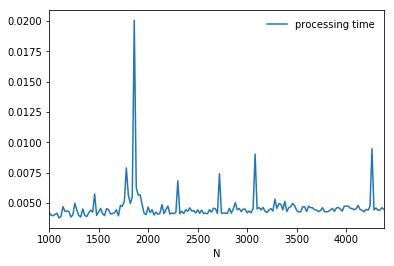

In [ ]:
def derive(data):
    new_data = data.copy()
    new_data["tt"] = new_data["t"] + 1  # MAP
    new_data = new_data.merge(new_data, left_on="t", right_on="tt", suffixes=("", "2")) # JOIN = MAP + REDUCE
    new_data["derivee"] = new_data["close"] - new_data["close2"] # MAP
    return new_data

import time, pandas
res = []
for n in range(1000, len(data), 20):
    df = data[0:n]
    mean = []
    for i in range(0, 50):
        t = time.clock()
        derive(df)
        dt = time.clock() - t
        mean.append(dt)
    print(n, min(mean), max(mean))
    res.append((n, mean[len(mean)//2]))
stat = pandas.DataFrame(res, columns=["N", "processing time"])
stat.plot(x="N", y=["processing time"])

### méthode inefficace

Dans ce cas, on fait un produit en croix de toutes les lignes de la bases avec elles-même puis on filtre le résultat pour ne garder que les lignes qui vérifient la condition souhaitée quelle qu'elle soit. Le temps d'exécution est en $O(N^2)$ et la différence est vite significative.

In [ ]:
new_data2 = data.copy()
new_data2["tt"] = new_data2["t"] + 1  # MAP
new_data2["key"] = 1
new_data2 = new_data2.merge(new_data2, on="key", suffixes=("", "2")) # JOIN = MAP = REDUCE
print(new_data2.shape)
new_data2 = new_data2[new_data2.t == new_data2.t2]
print(new_data2.shape)
new_data2["derivee"] = new_data2["t"] - new_data2["t2"] # MAP
new_data2.tail()

(19228225, 7)
(4385, 7)


,t,close,tt,key,t2,close2,tt2,derivee
19210680,2725,35.1550,2726,1,2725,35.1550,2726,0
19215066,550,61.1328,551,1,550,61.1328,551,0
19219452,1298,70.5634,1299,1,1298,70.5634,1299,0
19223838,65,211.1690,66,1,65,211.1690,66,0
19228224,1186,63.1232,1187,1,1186,63.1232,1187,0


## avec des itérateurs

## avec SQL